# GBDT with Bag of Words and TFIDF

### Importing the important libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string

from tqdm import tqdm
import os

#### Importing the dataset

In [2]:
df = pd.read_csv('preprocessed_data.csv')

## Calculating sentiment scores of essay using nltk

In [3]:
# Importing nltk and SentimentIntensityAnalyzer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [4]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chanchal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
# Initalizing SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [6]:
# Storing essay from the dataframe in a variable 'essay'
preprocessed_review_text = df['preprocessed_review_text']

In [7]:
# Getting polarity scores for each essay and storing it in a dictionary
scores_dict = df['preprocessed_review_text'].apply(lambda essay:sid.polarity_scores(str(essay)))

In [8]:
# Converting the dictionary to a dataframe, this will be used to merge with our main dataframe
df1=pd.DataFrame.from_records(scores_dict)

In [9]:
# Checking the head of the new dataframe
df1.head(1)

,neg,neu,pos,compound
0,0.0,0.093,0.907,0.8658


In [10]:
# Merging the main dataframe with the new dataframe
df=pd.merge(df, df1, left_index=True, right_index=True)

In [11]:
# The dataframe that will be used in our further analysis
df.head(1)

,Unnamed: 0,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Final_Price_after_Discount,Review_Link,Review_Creation_Date,Review_Rating_Score,preprocessed_review_text,preprocessed_product_name,preprocessed_review_header,neg,neu,pos,compound
0,0,1,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,69.97,https://www.homedepot.com/ReviewServices/revie...,2018-04-24,1,excellent fan excellent price,rockport_52_led_brushed_nickel_ceiling_fan_lig...,excellent fan excellent price,0.0,0.093,0.907,0.8658


### Splitting data into Train and Test: Stratified Sampling

In [12]:
# Segregating the dependent and independent variables as y and X respectively
y = df['Review_Rating_Score'].values
X = df.drop(['Review_Rating_Score','Unnamed: 0'], axis=1)
X.head(1)

,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Final_Price_after_Discount,Review_Link,Review_Creation_Date,preprocessed_review_text,preprocessed_product_name,preprocessed_review_header,neg,neu,pos,compound
0,1,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,69.97,https://www.homedepot.com/ReviewServices/revie...,2018-04-24,excellent fan excellent price,rockport_52_led_brushed_nickel_ceiling_fan_lig...,excellent fan excellent price,0.0,0.093,0.907,0.8658


In [13]:
# Splitting the data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [14]:
# Printing the shape of the data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(841, 17) (841,)
(281, 17) (281,)


# Bag of Words

### Review Text

In [15]:
# Implementing Bag of Words
vectorizer_bow = CountVectorizer(min_df=5)

In [16]:
# Applying fit method on 'preprocessed_review_text' column
vectorizer_bow.fit(X_train['preprocessed_review_text'].values) # fit has to happen only on train data

CountVectorizer(min_df=5)

In [17]:
# Applying transform method on train and test set
X_train_review_text_bow = vectorizer_bow.transform(X_train['preprocessed_review_text'].values)

In [18]:
X_test_review_text_bow = vectorizer_bow.transform(X_test['preprocessed_review_text'].values)

In [19]:
# Shape of the data after vectorization
print("After vectorizations")
print(X_train_review_text_bow.shape, y_train.shape)
print(X_test_review_text_bow.shape, y_test.shape)

After vectorizations
(841, 595) (841,)
(281, 595) (281,)


In [20]:
X_train.head(2)

,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Final_Price_after_Discount,Review_Link,Review_Creation_Date,preprocessed_review_text,preprocessed_product_name,preprocessed_review_header,neg,neu,pos,compound
714,750,Lowes,lighting_&_ceiling_fans,ceiling_fans_&_accessories,ceiling_fans,https://www.lowes.com/pd/Harbor-Breeze-Armitag...,harbor_breeze,49.98,https://www.lowes.com/pd/Harbor-Breeze-Armitag...,2018-11-27,large base covered old one easy install,harbor_breeze_armitage_52_brushed_nickel_led_i...,ceiling fan light,0.000,0.674,0.326,0.4404
475,502,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hunter-Channelside...,hunter,219.00,https://www.homedepot.com/ReviewServices/revie...,2018-08-16,fan great great installation instructions cool...,channelside_52_led_indoor_outdoor_noble_bronze...,fan great great installation instructions cool...,0.046,0.659,0.295,0.9776


### Review_Header

In [21]:
# Implementing Bag of Words
vectorizer_bow_rh = CountVectorizer(min_df=5)

In [22]:
# Applying fit method on 'preprocessed_review_text' column
vectorizer_bow_rh.fit(X_train['preprocessed_review_header'].values) # fit has to happen only on train data

CountVectorizer(min_df=5)

In [23]:
# Applying transform method on train and test set
X_train_review_header_bow = vectorizer_bow_rh.transform(X_train['preprocessed_review_header'].values)

In [24]:
X_test_review_header_bow = vectorizer_bow_rh.transform(X_test['preprocessed_review_header'].values)

In [25]:
# Shape of the data after vectorization
print("After vectorizations")
print(X_train_review_header_bow.shape, y_train.shape)
print(X_test_review_header_bow.shape, y_test.shape)

After vectorizations
(841, 114) (841,)
(281, 114) (281,)


## Encoding Numerical and Categorical Features

#### Encoding Categorical Feature: Retailer

In [26]:
vectorizer_r = CountVectorizer()
vectorizer_r.fit(X_train['Retailer'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_retailer_ohe = vectorizer_r.transform(X_train['Retailer'].values)
X_test_retailer_ohe = vectorizer_r.transform(X_test['Retailer'].values)

print("After vectorizations")
print(X_train_retailer_ohe.shape, y_train.shape)
print(X_test_retailer_ohe.shape, y_test.shape)
print(vectorizer_r.get_feature_names())
print("="*100)

After vectorizations
(841, 2) (841,)
(281, 2) (281,)
['homedepot', 'lowes']


#### Encoding Categorical Feature: Division

In [27]:
vectorizer_d = CountVectorizer()
vectorizer_d.fit(X_train['Division'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_division_ohe = vectorizer_d.transform(X_train['Division'].values)
X_test_division_ohe = vectorizer_d.transform(X_test['Division'].values)

print("After vectorizations")
print(X_train_division_ohe.shape, y_train.shape)
print(X_test_division_ohe.shape, y_test.shape)
print(vectorizer_d.get_feature_names())
print("="*100)

After vectorizations
(841, 3) (841,)
(281, 3) (281,)
['_ceiling_fans', 'lighting', 'lighting_']


#### Encoding Categorical Feature: Category

In [28]:
vectorizer_c = CountVectorizer()
vectorizer_c.fit(X_train['Category'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_category_ohe = vectorizer_d.transform(X_train['Category'].values)
X_test_category_ohe = vectorizer_d.transform(X_test['Category'].values)

print("After vectorizations")
print(X_train_category_ohe.shape, y_train.shape)
print(X_test_category_ohe.shape, y_test.shape)
print(vectorizer_c.get_feature_names())
print("="*100)

After vectorizations
(841, 3) (841,)
(281, 3) (281,)
['_accessories', 'ceiling_fans', 'ceiling_fans_']


#### Encoding Categorical Feature: Department

In [29]:
vectorizer_de = CountVectorizer()
vectorizer_de.fit(X_train['Department'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_department_ohe = vectorizer_d.transform(X_train['Department'].values)
X_test_department_ohe = vectorizer_d.transform(X_test['Department'].values)

print("After vectorizations")
print(X_train_department_ohe.shape, y_train.shape)
print(X_test_department_ohe.shape, y_test.shape)
print(vectorizer_de.get_feature_names())
print("="*100)

After vectorizations
(841, 3) (841,)
(281, 3) (281,)
['ceiling_fans', 'ceiling_fans_with_lights', 'ceiling_fans_without_lights']


#### Encoding Categorical Feature: Brand

In [30]:
vectorizer_b = CountVectorizer()
vectorizer_b.fit(X_train['Brand'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_brand_ohe = vectorizer_d.transform(X_train['Brand'].values)
X_test_brand_ohe = vectorizer_d.transform(X_test['Brand'].values)

print("After vectorizations")
print(X_train_brand_ohe.shape, y_train.shape)
print(X_test_brand_ohe.shape, y_test.shape)
print(vectorizer_b.get_feature_names())
print("="*100)

After vectorizations
(841, 3) (841,)
(281, 3) (281,)
['brand_not_mentioned', 'fanimation_studio_collection', 'hampton_bay', 'harbor_breeze', 'home_decorators_collection', 'hunter', 'kichler']


#### Encoding Categorical Feature: preprocessed_product_name

In [31]:
vectorizer_pn = CountVectorizer()
vectorizer_pn.fit(X_train['preprocessed_product_name'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_pn_ohe = vectorizer_pn.transform(X_train['preprocessed_product_name'].values)
X_test_pn_ohe = vectorizer_pn.transform(X_test['preprocessed_product_name'].values)

print("After vectorizations")
print(X_train_pn_ohe.shape, y_train.shape)
print(X_test_pn_ohe.shape, y_test.shape)
print(vectorizer_pn.get_feature_names())
print("="*100)

After vectorizations
(841, 76) (841,)
(281, 76) (281,)
['altura_60_outdoor_oil_rubbed_bronze_ceiling_fan', 'altura_68_indoor_oil_rubbed_bronze_ceiling_fan_remote_control', 'antero_46_led_indoor_brushed_nickel_ceiling_fan_light', 'ashby_park_44_white_color_changing_integrated_led_brushed_nickel_ceiling_fan_light_kit', 'ashby_park_52_white_color_changing_integrated_led_brushed_nickel_ceiling_fan_light_kit_remote_control', 'barnes_bay_52_led_indoor_outdoor_natural_iron_ceiling_fan_light_kit', 'bellina_42_oil_rubbed_bronze_ceiling_fan_led_light_kit', 'brette_23_led_indoor_outdoor_brushed_nickel_ceiling_fan_light_kit_remote_control', 'brookhurst_52_led_indoor_white_ceiling_fan_light_kit', 'channelside_52_led_indoor_outdoor_noble_bronze_ceiling_fan_remote_control', 'channing_54_led_indoor_easy_install_noble_bronze_ceiling_fan_hunterexpress_feature_set', 'clarkston_ii_44_led_indoor_brushed_nickel_ceiling_fan_light_kit', 'connor_54_led_brushed_nickel_dual_mount_ceiling_fan_light_kit_remote_con

#### Encoding Numerical Feature: Price

In [32]:
from sklearn.preprocessing import Normalizer
normalizer_pr = Normalizer()

normalizer_pr.fit(X_train['Final_Price_after_Discount'].values.reshape(-1,1)) # Applying fit method on train data after reshaping the data

X_train_price_norm = normalizer_pr.transform(X_train['Final_Price_after_Discount'].values.reshape(-1,1)) # Applying transform method on train and test
X_test_price_norm = normalizer_pr.transform(X_test['Final_Price_after_Discount'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(841, 1) (841,)
(281, 1) (281,)


#### Encoding Numerical Feature: neg

In [33]:
from sklearn.preprocessing import Normalizer
normalizer_neg = Normalizer()

# Applying fit method on train data after reshaping the data
normalizer_neg.fit(X_train['neg'].values.reshape(-1,1))

# Applying transform method on train and test
X_train_neg_norm = normalizer_neg.transform(X_train['neg'].values.reshape(-1,1))
X_test_neg_norm = normalizer_neg.transform(X_test['neg'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_neg_norm.shape, y_train.shape)
print(X_test_neg_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(841, 1) (841,)
(281, 1) (281,)


#### Encoding Numerical Feature: neu

In [34]:
from sklearn.preprocessing import Normalizer
normalizer_neu = Normalizer()

# Applying fit method on train data after reshaping the data
normalizer_neu.fit(X_train['neu'].values.reshape(-1,1))

# Applying transform method on train and test
X_train_neu_norm = normalizer_neu.transform(X_train['neu'].values.reshape(-1,1))
X_test_neu_norm = normalizer_neu.transform(X_test['neu'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_neu_norm.shape, y_train.shape)
print(X_test_neu_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(841, 1) (841,)
(281, 1) (281,)


#### Encoding Numerical Feature: pos

In [35]:
from sklearn.preprocessing import Normalizer
normalizer_pos = Normalizer()

# Applying fit method on train data after reshaping the data
normalizer_pos.fit(X_train['pos'].values.reshape(-1,1))

# Applying transform method on train and test
X_train_pos_norm = normalizer_pos.transform(X_train['pos'].values.reshape(-1,1))
X_test_pos_norm = normalizer_pos.transform(X_test['pos'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_pos_norm.shape, y_train.shape)
print(X_test_pos_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(841, 1) (841,)
(281, 1) (281,)


#### Encoding Numerical Feature: compound

In [36]:
from sklearn.preprocessing import Normalizer
normalizer_com = Normalizer()

# Applying fit method on train data after reshaping the data
normalizer_com.fit(X_train['compound'].values.reshape(-1,1))

# Applying transform method on train and test
X_train_com_norm = normalizer_com.transform(X_train['compound'].values.reshape(-1,1))
X_test_com_norm = normalizer_com.transform(X_test['compound'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_com_norm.shape, y_train.shape)
print(X_test_com_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(841, 1) (841,)
(281, 1) (281,)


### Concatinating all the features

In [37]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_review_text_bow,X_train_review_header_bow, X_train_retailer_ohe, X_train_division_ohe,X_train_category_ohe,X_train_department_ohe,X_train_brand_ohe,X_train_pn_ohe,X_train_price_norm,X_train_neg_norm,X_train_neu_norm,X_train_pos_norm,X_train_com_norm)).tocsr()
X_te = hstack((X_test_review_text_bow,X_test_review_header_bow, X_test_retailer_ohe, X_test_division_ohe,X_test_category_ohe,X_test_department_ohe,X_test_brand_ohe,X_test_pn_ohe,X_test_price_norm,X_test_neg_norm,X_test_neu_norm,X_test_pos_norm,X_test_com_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(841, 804) (841,)
(281, 804) (281,)


### Applying Random Search CV to find the best hyperparameter

In [38]:
# Importing required libraries
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import lightgbm as LGBMClassifier

In [39]:
# List of hyperparameters
param_test ={'num_leaves': [6, 10, 15, 25, 35, 50],'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

#Initializing the classifier and random search cv
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 1000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=123, silent=True, metric='None', n_jobs=-1, n_estimators=1000, class_weight='balanced')
gs = RandomizedSearchCV(estimator=clf, param_distributions=param_test,n_iter=10,scoring='roc_auc',cv=3,refit=True,random_state=123,n_jobs=-1,verbose=1,return_train_score=True)

In [40]:
# Fitting the random search cv to train and test data
gs.fit(X_tr, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.0s finished


RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            metric='None', n_estimators=1000,
                                            random_state=123),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3],
                                        'num_leaves': [6, 10, 15, 25, 35, 50]},
                   random_state=123, return_train_score=True, scoring='roc_auc',
                   verbose=1)

In [41]:
# Let's store the results of CV in a pandas dataframe
results = pd.DataFrame.from_dict(gs.cv_results_)

In [42]:
results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.983438,0.185087,0.063481,0.004778,6,0.001,"{'num_leaves': 6, 'learning_rate': 0.001}",0.903888,0.874708,0.853854,0.877483,0.02052,9,0.916653,0.918546,0.938861,0.924687,0.010053


In [43]:
# Let us sort values based of the param_alpha column which will sort values in ascending order of alpha
results = results.sort_values(['param_learning_rate'])

In [44]:
results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
4,1.45754,0.020023,0.058746,0.013456,50,0.0001,"{'num_leaves': 50, 'learning_rate': 0.0001}",0.892463,0.838505,0.841953,0.85764,0.024663,10,0.892142,0.897202,0.933539,0.907628,0.018438


Text(33.0, 0.5, 'N Estimators')

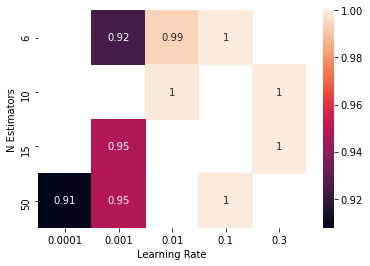

In [45]:
# Heatmap between Max Depth and Min Sample Split on Train Data
train_auc_heatmap = results.pivot("param_num_leaves", "param_learning_rate", "mean_train_score")
ax = sns.heatmap(train_auc_heatmap, annot=True)
plt.xlabel('Learning Rate')
plt.ylabel('N Estimators')

Text(33.0, 0.5, 'N Estimators')

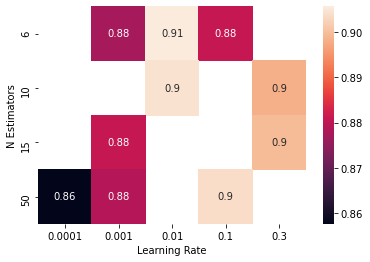

In [46]:
# Heatmap between Max Depth and Min Sample Split on Train Data
train_auc_heatmap = results.pivot("param_num_leaves", "param_learning_rate", "mean_test_score")
ax = sns.heatmap(train_auc_heatmap, annot=True)
plt.xlabel('Learning Rate')
plt.ylabel('N Estimators')

In [47]:
# Best hyperparameters identified from the above test heatmap
best_learning_rate = .1
best_num_leaves = 10

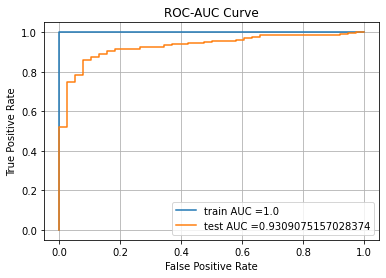

In [48]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

# Final LGBM model using the best hyperparameters
lgbm_final_tfidf = lgb.LGBMClassifier(learning_rate=best_learning_rate, num_leaves=best_num_leaves, max_depth=-1, random_state=123, silent=True, metric='None', n_jobs=-1, n_estimators=1000, class_weight='balanced')
lgbm_final_tfidf.fit(X_tr, y_train)

y_train_pred = lgbm_final_tfidf.predict_proba(X_tr)[:,1]   
y_test_pred = lgbm_final_tfidf.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
#plt.xscale('log')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.grid()
plt.show()

In [49]:
# we are writing our own function to predict, with defined thresold
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [50]:
# Printing confusion matrix
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 1.0 for threshold 0.999
Train confusion matrix
[[112   0]
 [  0 729]]
Test confusion matrix
[[ 31   7]
 [ 20 223]]


In [51]:
cm_train=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
cm_test=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

Text(33.0, 0.5, 'Actual')

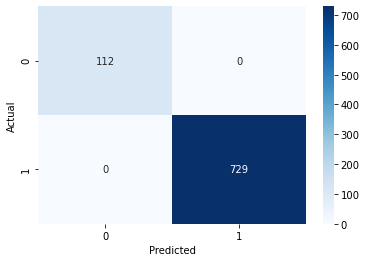

In [52]:
sns.heatmap(cm_train, annot=True,fmt="d",cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(33.0, 0.5, 'Actual')

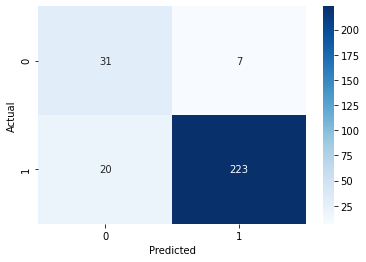

In [53]:
sns.heatmap(cm_test, annot=True,fmt="d",cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## TFIDF

### Review_Text

In [54]:
# Implementing TF-IDF
vectorizer_tfidf = TfidfVectorizer(min_df=5)
vectorizer_tfidf.fit(X_train['preprocessed_review_text'].values) #(Fit Method)

TfidfVectorizer(min_df=5)

In [55]:
# Transform method on train and test data
X_train_rt_tfidf = vectorizer_tfidf.transform(X_train['preprocessed_review_text'].values)

In [56]:
X_test_rt_tfidf = vectorizer_tfidf.transform(X_test['preprocessed_review_text'].values)

In [57]:
print("After vectorizations")
print(X_train_rt_tfidf.shape, y_train.shape)
print(X_test_rt_tfidf.shape, y_test.shape)

After vectorizations
(841, 595) (841,)
(281, 595) (281,)


### Review_Header

In [58]:
# Implementing TF-IDF
vectorizer_tfidf_rh = TfidfVectorizer(min_df=5)
vectorizer_tfidf_rh.fit(X_train['preprocessed_review_header'].values) #(Fit Method)

TfidfVectorizer(min_df=5)

In [59]:
# Transform method on train and test data
X_train_rh_tfidf = vectorizer_tfidf_rh.transform(X_train['preprocessed_review_header'].values)

In [60]:
X_test_rh_tfidf = vectorizer_tfidf_rh.transform(X_test['preprocessed_review_text'].values)

In [61]:
print("After vectorizations")
print(X_train_rh_tfidf.shape, y_train.shape)
print(X_test_rh_tfidf.shape, y_test.shape)

After vectorizations
(841, 114) (841,)
(281, 114) (281,)


### Concatinating all the features

In [62]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_rt_tfidf,X_train_rh_tfidf, X_train_retailer_ohe, X_train_division_ohe,X_train_category_ohe,X_train_department_ohe,X_train_brand_ohe,X_train_pn_ohe,X_train_price_norm )).tocsr()
X_te = hstack((X_test_rt_tfidf,X_test_rh_tfidf, X_test_retailer_ohe, X_test_division_ohe,X_test_category_ohe,X_test_department_ohe,X_test_brand_ohe,X_test_pn_ohe,X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(841, 800) (841,)
(281, 800) (281,)


### Applying Random Search CV to find the best hyperparameter

In [63]:
# Importing required libraries
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import lightgbm as LGBMClassifier

In [64]:
# List of hyperparameters
param_test ={'num_leaves': [6, 10, 15, 25, 35, 50],'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

#Initializing the classifier and random search cv
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 1000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=123, silent=True, metric='None', n_jobs=-1, n_estimators=1000, class_weight='balanced')
gs = RandomizedSearchCV(estimator=clf, param_distributions=param_test,n_iter=10,scoring='roc_auc',cv=3,refit=True,random_state=123,n_jobs=-1,verbose=1,return_train_score=True)

In [65]:
# Fitting the random search cv to train and test data
gs.fit(X_tr, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.3s finished


RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            metric='None', n_estimators=1000,
                                            random_state=123),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3],
                                        'num_leaves': [6, 10, 15, 25, 35, 50]},
                   random_state=123, return_train_score=True, scoring='roc_auc',
                   verbose=1)

In [66]:
# Let's store the results of CV in a pandas dataframe
results = pd.DataFrame.from_dict(gs.cv_results_)

In [67]:
# Let us sort values based of the param_alpha column which will sort values in ascending order of alpha
results = results.sort_values(['param_learning_rate'])

In [68]:
results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
4,1.530166,0.03931,0.054715,0.017992,50,0.0001,"{'num_leaves': 50, 'learning_rate': 0.0001}",0.783084,0.845234,0.739851,0.78939,0.043253,10,0.900345,0.890137,0.922716,0.904399,0.013606


Text(33.0, 0.5, 'N Estimators')

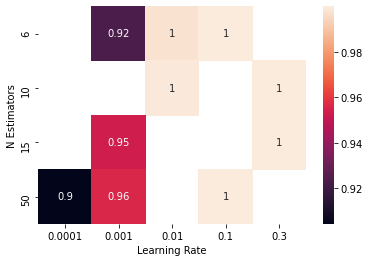

In [69]:
# Heatmap between Max Depth and Min Sample Split on Train Data
train_auc_heatmap = results.pivot("param_num_leaves", "param_learning_rate", "mean_train_score")
ax = sns.heatmap(train_auc_heatmap, annot=True)
plt.xlabel('Learning Rate')
plt.ylabel('N Estimators')

Text(33.0, 0.5, 'N Estimators')

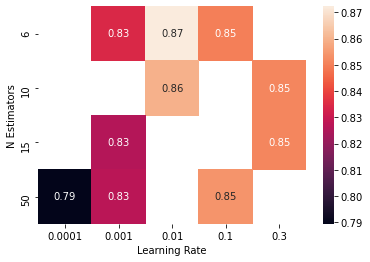

In [70]:
# Heatmap between Max Depth and Min Sample Split on Train Data
train_auc_heatmap = results.pivot("param_num_leaves", "param_learning_rate", "mean_test_score")
ax = sns.heatmap(train_auc_heatmap, annot=True)
plt.xlabel('Learning Rate')
plt.ylabel('N Estimators')

In [71]:
# Best hyperparameters identified from the above test heatmap
best_learning_rate = .01
best_num_leaves = 6

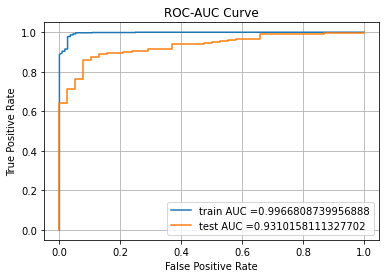

In [72]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

# Final LGBM model using the best hyperparameters
lgbm_final_tfidf = lgb.LGBMClassifier(learning_rate=best_learning_rate, num_leaves=best_num_leaves, max_depth=-1, random_state=123, silent=True, metric='None', n_jobs=-1, n_estimators=1000, class_weight='balanced')
lgbm_final_tfidf.fit(X_tr, y_train)

y_train_pred = lgbm_final_tfidf.predict_proba(X_tr)[:,1]   
y_test_pred = lgbm_final_tfidf.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
#plt.xscale('log')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.grid()
plt.show()

In [73]:
# we are writing our own function to predict, with defined thresold
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [74]:
# Printing confusion matrix
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.9518543013913384 for threshold 0.405
Train confusion matrix
[[109   3]
 [ 16 713]]
Test confusion matrix
[[ 24  14]
 [ 15 228]]


In [75]:
cm_train=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
cm_test=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

### Train Confusion Matrix

Text(33.0, 0.5, 'Actual')

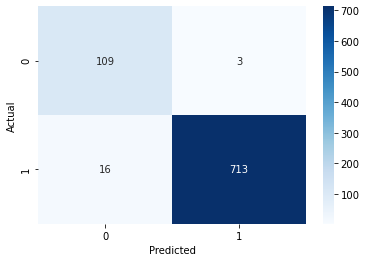

In [76]:
sns.heatmap(cm_train, annot=True,fmt="d",cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### Test Confusion Matrix

Text(33.0, 0.5, 'Actual')

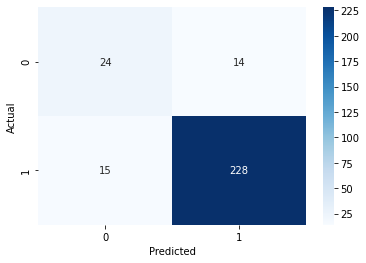

In [77]:
sns.heatmap(cm_test, annot=True,fmt="d",cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [1]:
# Summarizing the results
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Learning_Rate","N_Estimators" ,"Train-AUC", "Test-AUC"]
x.add_row(["Bag of Words", "Light GBM", 0.1, 10, 1.00, .93])
x.add_row(["TFIDF", "Light GBM", 0.01, 6, .99, .931])
print(x)

+--------------+-----------+---------------+--------------+-----------+----------+
|  Vectorizer  |   Model   | Learning_Rate | N_Estimators | Train-AUC | Test-AUC |
+--------------+-----------+---------------+--------------+-----------+----------+
| Bag of Words | Light GBM |      0.1      |      10      |    1.0    |   0.93   |
|    TFIDF     | Light GBM |      0.01     |      6       |    0.99   |  0.931   |
+--------------+-----------+---------------+--------------+-----------+----------+
